In [1]:
import pandas as pd
import sqlalchemy as sa
import pyodbc
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import beta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  

In [2]:
conn_str = (
    "mssql+pyodbc://DESKTOP-2DQ736S\\SQLEXPRESS/test"
    "?driver=SQL+Server"
    "&trusted_connection=yes"
)

In [3]:
engine = sa.create_engine(conn_str)
query = "SELECT * FROM test.dbo.promo_metrics;"
df = pd.read_sql(query, engine)

In [4]:
df["delta_CR"] = df["CR_test"] - df["CR_ctrl"]
df["delta_AOV"] = df["AOV_test"] - df["AOV_ctrl"]
df["delta_revenue"] = df["delta_AOV"] * df["buyers_test"]

In [5]:
df = df.sort_values("promoid")

In [6]:
df["z_score_CR"] = np.nan
df["p_value_CR"] = np.nan

In [7]:
for idx, row in df.iterrows():
    count = [row["buyers_test"], row["buyers_ctrl"]]
    nobs = [row["customers_test"], row["customers_ctrl"]]

    if nobs[0] == 0 or nobs[1] == 0:
        continue

    z, p = proportions_ztest(count, nobs)

    df.loc[idx, "z_score_CR"] = z
    df.loc[idx, "p_value_CR"] = p

c:\Users\Tanya\anaconda3\envs\env_ml\lib\site-packages\statsmodels\stats\weightstats.py:790: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std


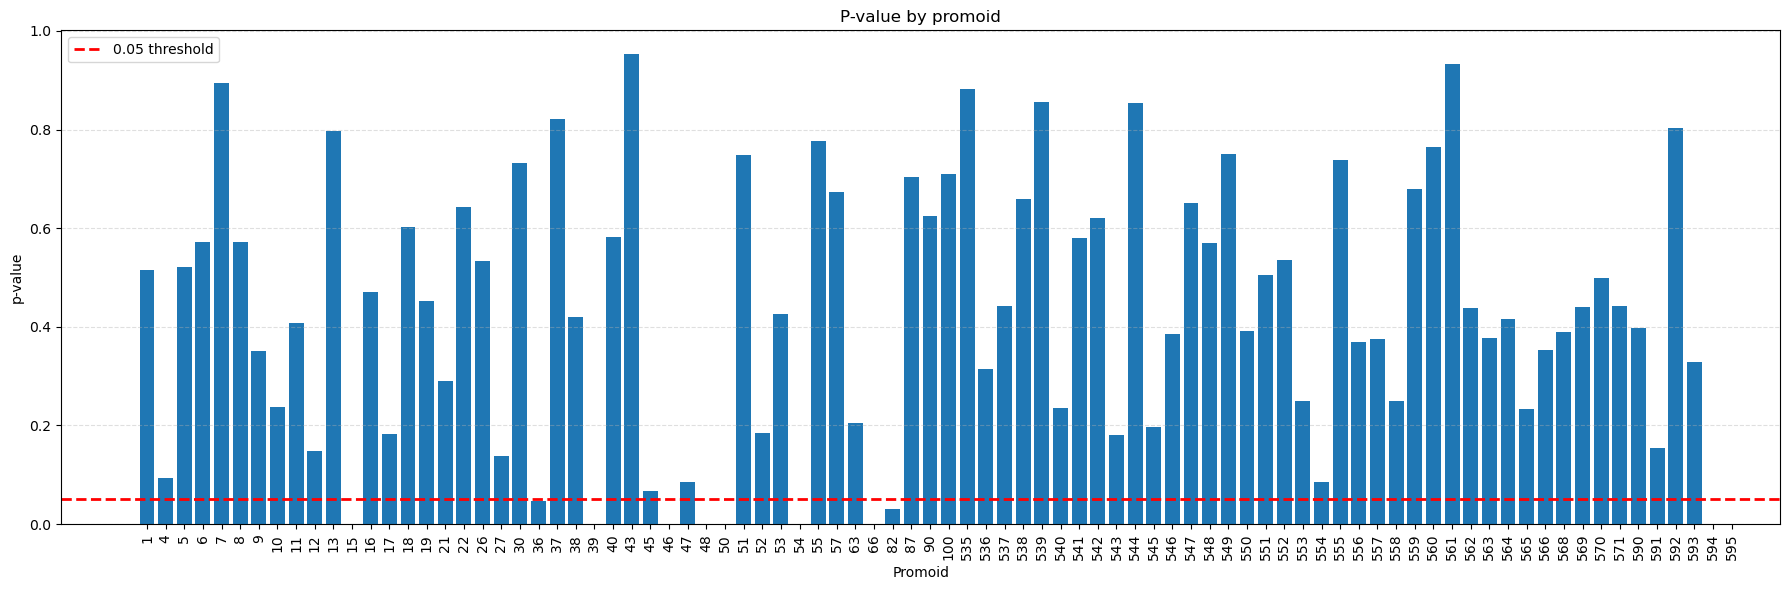

In [8]:
plt.figure(figsize=(18, 6))
plt.bar(df["promoid"].astype(str), df["p_value_CR"])

plt.axhline(0.05, color="red", linestyle="--", linewidth=2, label="0.05 threshold")

plt.xlabel("Promoid")
plt.ylabel("p-value")
plt.title("P-value by promoid")

plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()

plt.tight_layout()

In [9]:
N = 50000

df["bayes_prob_CR"] = np.nan
df["bayes_uplift_CR"] = np.nan

for idx, row in df.iterrows():

    if row["customers_ctrl"] == 0:
        continue

    a_test = row["buyers_test"] + 1
    b_test = (row["customers_test"] - row["buyers_test"]) + 1

    a_ctrl = row["buyers_ctrl"] + 1
    b_ctrl = (row["customers_ctrl"] - row["buyers_ctrl"]) + 1

    test_samples = beta.rvs(a_test, b_test, size=N)
    ctrl_samples = beta.rvs(a_ctrl, b_ctrl, size=N)

    prob = np.mean(test_samples > ctrl_samples)

    uplift = np.mean(test_samples - ctrl_samples)

    df.loc[idx, "bayes_prob_CR"] = prob
    df.loc[idx, "bayes_uplift_CR"] = uplift

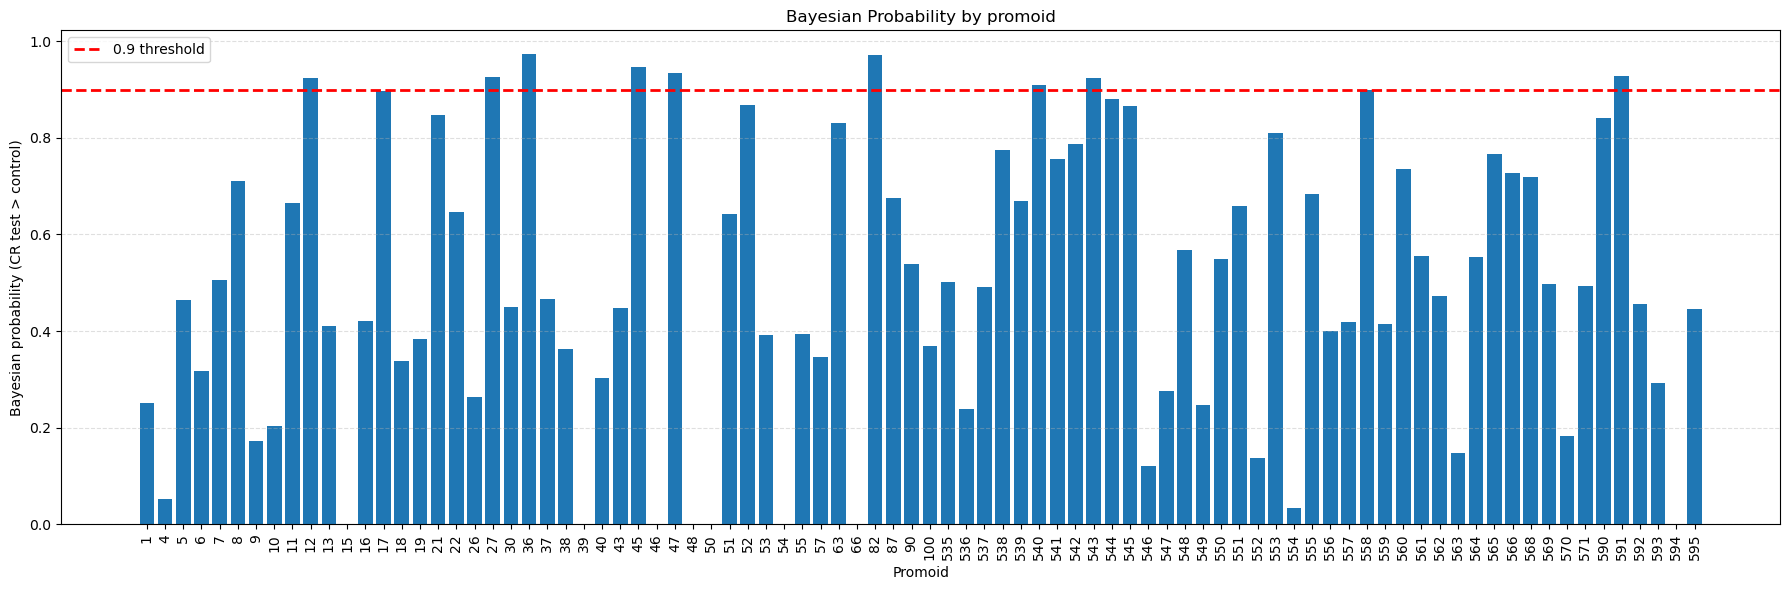

In [10]:
plt.figure(figsize=(18, 6))

plt.bar(df["promoid"].astype(str), df["bayes_prob_CR"])

plt.axhline(0.9, color="red", linestyle="--", linewidth=2, label="0.9 threshold")

plt.xlabel("Promoid")
plt.ylabel("Bayesian probability (CR test > control)")
plt.title("Bayesian Probability by promoid")

plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()

plt.tight_layout()

Виберемо promoid в яких bayesian probability більше 0,95. Вони мають значущий ефект на збільшення конверсії

In [30]:
df[df["bayes_prob_CR"]>0.95]

,promoid,customers_test,customers_ctrl,buyers_test,buyers_ctrl,checks_test,checks_ctrl,gross_test,gross_ctrl,revenue_test,...,CR_ctrl,AOV_test,AOV_ctrl,delta_CR,delta_AOV,delta_revenue,z_score_CR,p_value_CR,bayes_prob_CR,bayes_uplift_CR
45,36,218,23,123,8,123,8,37352.0,2482.0,37062.0,...,0.347826,301.317073,310.125,0.216394,-8.807927,-1083.375021,1.981591,0.047525,0.97580,0.204233
62,82,20,2,15,0,15,0,5484.0,0.0,5456.0,...,0.000000,363.733333,0.000,0.750000,363.733333,5455.999995,2.171241,0.029913,0.97292,0.477531


Promoid 36 показує статистично достовірне зростання конверсії, підтверджене як класичними методами, так і байєсівським аналізом.
Результат можна вважати успішним та рекомендованим до масштабування.

Результати для promoid 82 також виглядають дуже успішними, але варто мати на увазі малий розмір контрольної групи, через що завищений апліфт, та воно демонструє сильний і статистично підтверджений позитивний ефект.

Promoid в яких bayesian probability більше 0,9 можуть також мати значущий вплив, але потребцють додаткових досліджень, наприклад збільшення вибірки.

In [32]:
df[(df["bayes_prob_CR"]>0.9) & (df["bayes_prob_CR"]<0.95)]

,promoid,customers_test,customers_ctrl,buyers_test,buyers_ctrl,checks_test,checks_ctrl,gross_test,gross_ctrl,revenue_test,...,CR_ctrl,AOV_test,AOV_ctrl,delta_CR,delta_AOV,delta_revenue,z_score_CR,p_value_CR,bayes_prob_CR,bayes_uplift_CR
17,12,85,15,51,6,51,6,15885.0,1831.0,15752.0,...,0.400000,308.862745,305.166666,0.200000,3.696079,188.500029,1.442492,0.149164,0.92268,0.186526
75,17,181,14,85,4,85,4,23058.0,1108.0,22395.0,...,0.285714,263.470588,277.000000,0.183899,-13.529412,-1150.000020,1.330920,0.183215,0.90078,0.157980
30,27,269,26,134,9,135,9,37710.0,2087.0,37307.0,...,0.346154,276.348148,231.222222,0.151987,45.125926,6046.874084,1.480784,0.138664,0.92716,0.140893
63,45,18,2,12,0,12,0,4432.0,0.0,4429.0,...,0.000000,369.083333,0.000000,0.666667,369.083333,4428.999996,1.825742,0.067889,0.94440,0.400122
36,47,59,3,30,0,30,0,7518.0,0.0,7407.0,...,0.000000,246.900000,0.000000,0.508475,246.900000,7407.000000,1.719159,0.085585,0.93450,0.308492
57,540,259,22,233,18,235,18,86629.0,6508.0,86042.0,...,0.818182,366.136170,361.277777,0.081432,4.858393,1132.005569,1.187442,0.235053,0.91008,0.105273
64,543,239,22,209,17,211,17,73513.0,5278.0,72703.0,...,0.772727,344.563981,309.058823,0.101750,35.505158,7420.578022,1.340218,0.180174,0.92302,0.120989
76,558,259,25,228,20,232,21,86825.0,6264.0,86095.0,...,0.800000,371.099137,298.095238,0.080309,73.003899,16644.888972,1.152565,0.249089,0.90336,0.100031
35,591,44,8,37,5,37,5,12097.0,1312.0,11806.0,...,0.625000,319.081081,253.200000,0.215909,65.881081,2437.599997,1.425343,0.154058,0.92864,0.226108


In [28]:
if "CR_Rank" in df.columns:
    df = df.drop(columns=["CR_Rank"])

df_nonempty = df[df["bayes_prob_CR"].notna()].copy()

df_nonempty["CR_Rank"] = (
    df_nonempty["bayes_uplift_CR"]
    .rank(method="dense", ascending=False)
    .astype(int)
)

df = df.merge(
    df_nonempty[["promoid", "CR_Rank"]],
    on="promoid",
    how="left"
)

df.to_excel("promo_results.xlsx", index=False, engine="openpyxl")